In [1]:
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf 
from skimage.transform import resize
from keras import backend as K
from keras.layers import Input, Lambda, Conv2D
from keras.models import load_model, Model
  
import sys
yolo_utils="../input/yolo-utils/yolo_utils.py"
sys.path.append(sys.path.append(os.path.dirname(os.path.expanduser(yolo_utils))))

yad2k="../input/obj-localisation-files/dataset and libraries/week3/yad2k"
sys.path.append(sys.path.append(os.path.dirname(os.path.expanduser(yad2k))))

from yolo_utils import read_classes, read_anchors, generate_colors, preprocess_image, draw_boxes, scale_boxes
from yad2k.models.keras_yolo import yolo_head, yolo_boxes_to_corners, preprocess_true_boxes, yolo_loss, yolo_body


Using TensorFlow backend.


In [2]:
def yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = .6):
    box_scores = box_confidence*box_class_probs
    box_classes = K.argmax(box_scores,-1)
    box_class_scores = K.max(box_scores,-1)
    filtering_mask = box_class_scores>threshold
    scores = tf.boolean_mask(box_class_scores,filtering_mask)
    boxes = tf.boolean_mask(boxes,filtering_mask)
    classes = tf.boolean_mask(box_classes,filtering_mask)
 
    return scores, boxes, classes

In [3]:
def iou(box1, box2):
    xi1 = max(box1[0],box2[0])
    yi1 = max(box1[1],box2[1])
    xi2 = min(box1[2],box2[2])
    yi2 = min(box1[3],box2[3])
    inter_area = (yi2-yi1)*(xi2-xi1)
    box1_area = (box1[3]-box1[1])*(box1[2]-box1[0])
    box2_area = (box2[3]-box2[1])*(box2[2]-box2[0])
    union_area = box1_area+box2_area-inter_area
    iou = inter_area/union_area
 
    return iou

In [4]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    max_boxes_tensor = K.variable(max_boxes, dtype='int32')
    K.get_session().run(tf.variables_initializer([max_boxes_tensor]))
    nms_indices = tf.image.non_max_suppression(boxes,scores,max_boxes,iou_threshold)
    scores = K.gather(scores,nms_indices)
    boxes = K.gather(boxes,nms_indices)
    classes = K.gather(classes,nms_indices)

    return scores, boxes, classes

In [5]:
yolo_outputs = (tf.random_normal([19, 19, 5, 1], mean=1, stddev=4, seed = 1),
                   tf.random_normal([19, 19, 5, 2], mean=1, stddev=4, seed = 1),
                   tf.random_normal([19, 19, 5, 2], mean=1, stddev=4, seed = 1),
                   tf.random_normal([19, 19, 5, 80], mean=1, stddev=4, seed = 1))

In [6]:
def yolo_eval(yolo_outputs, image_shape = (720., 1280.), max_boxes=10, score_threshold=.6, iou_threshold=.5):
    box_confidence, box_xy, box_wh, box_class_probs = yolo_outputs
    boxes = yolo_boxes_to_corners(box_xy, box_wh)
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = score_threshold)
    boxes = scale_boxes(boxes, image_shape)
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes, iou_threshold)

    return scores, boxes, classes

In [7]:
scores, boxes, classes = yolo_eval(yolo_outputs)

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
with tf.Session() as test_b:
    print("scores[2] = " + str(scores[2].eval()))
    print("boxes[2] = " + str(boxes[2].eval()))
    print("classes[2] = " + str(classes[2].eval()))

scores[2] = 138.79124
boxes[2] = [1292.3297  -278.52167 3876.9893  -835.56494]
classes[2] = 54


In [9]:
sess = K.get_session()


In [10]:
class_names = read_classes("../input/obj-localisation-files/dataset and libraries/week3/model_data/coco_classes.txt")

In [11]:

anchors = read_anchors("../input/obj-localisation-files/dataset and libraries/week3/model_data/yolo_anchors.txt")

In [12]:
yolo_model = load_model("../input/obj-localisation-files/dataset and libraries/week3/model_data/yolo.h5")

/opt/conda/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [13]:
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))

In [14]:
def predict(sess, image_file):
    image, image_data = preprocess_image("../input/obj-localisation-files/dataset and libraries/week3/images/" + image_file, model_image_size = (608, 608))
    out_scores, out_boxes, out_classes = sess.run([scores, boxes, classes], feed_dict={yolo_model.input: image_data, K.learning_phase(): 0})

    print('Found {} boxes for {}'.format(len(out_boxes), image_file))

    # Generate colors for drawing bounding boxes.
    colors = generate_colors(class_names)

    # Draw bounding boxes on the image file
    draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)

    # Save the predicted bounding box on the image
    image.save(os.path.join("../", image_file), quality=90)

    # Display the results in the notebook
    output_image = scipy.misc.imread(os.path.join("../", image_file))

    plt.figure(figsize=(7,7))
    imshow(output_image)

    return out_scores, out_boxes, out_classes

In [15]:
img = plt.imread('../input/obj-localisation-files/dataset and libraries/week3/images/car.jpeg')
image_shape = float(img.shape[0]), float(img.shape[1])
scores, boxes, classes = yolo_eval(yolo_outputs, image_shape)

Found 1 boxes for car.jpeg
car 0.79 (62, 54) (250, 152)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


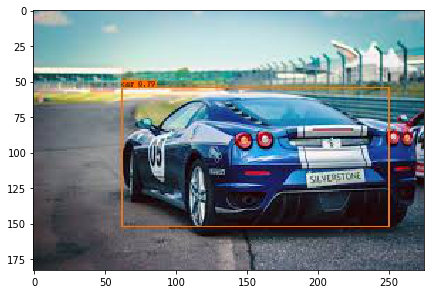

In [16]:
out_scores, out_boxes, out_classes = predict(sess, "car.jpeg")
